In [7]:
# First lets improve libraries that we are going to be used in this lab session
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
random.seed(134)
import pandas as pd
PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 32

In [2]:
train=pd.read_csv('hw2_data/snli_train.tsv',delimiter='\t',encoding='utf-8')
val=pd.read_csv('hw2_data/snli_val.tsv',delimiter='\t',encoding='utf-8')

In [8]:
train=pd.read_csv('hw2_data/mnli_train.tsv',delimiter='\t',encoding='utf-8')
val=pd.read_csv('hw2_data/mnli_val.tsv',delimiter='\t',encoding='utf-8')

In [12]:
train

,sentence1,sentence2,label,genre
0,and now that was in fifty one that 's forty ye...,It was already a problem forty years ago but n...,neutral,telephone
1,Jon could smell baked bread on the air and his...,Jon smelt food in the air and was hungry .,neutral,fiction
2,it will be like Italian basketball with the uh...,This type of Italian basketball is nothing lik...,contradiction,telephone
3,well i think that 's about uh that 's about co...,Sorry but we are not done just yet .,contradiction,telephone
4,"Good job tenure , that is -- because in yet an...","Dr. Quinn , Medicine Woman , was worked on by ...",entailment,slate
5,"Second , the Senate request asked EPA to assum...",The EPA started running the policy scenarios a...,neutral,government
6,have to see what uh April or May have to offer,We have to see how April and May will be .,entailment,telephone
7,"Finally , boards have a clear responsibility t...",Management needs to be held accountable for re...,neutral,government
8,3 The Reorganization Act replaced this statuto...,Postal Service Governors are not authorized to...,neutral,government
9,yeah he was pretty good staying on the sidelin...,He performed fantastically in the game .,contradiction,telephone


In [3]:
train_targets=list(train['label'])
val_targets=list(val['label'])

In [4]:
val_targets= [0 if x=='entailment' else x for x in val_targets]
train_targets= [0 if x=='entailment' else x for x in train_targets]
val_targets= [1 if x=='neutral' else x for x in val_targets]
train_targets= [1 if x=='neutral' else x for x in train_targets]
val_targets= [2 if x=='contradiction' else x for x in val_targets]
train_targets= [2 if x=='contradiction' else x for x in train_targets]

In [5]:
train_sen1= list(train['sentence1'])
train_sen2= list(train['sentence2'])
val_sen1= list(val['sentence1'])
val_sen2= list(val['sentence2'])

In [6]:
a=[]
b=[]
for i in range(0,100000):
    tmp1=''
    tmp2=''
    for j in train_sen1[i].split(' '):
        tmp1 =tmp1 + ' ' + j
    for j in train_sen2[i].split(' '):
        tmp2=tmp2 + ' ' + j
    a.append(tmp1[1:])
    b.append(tmp2[1:])

In [7]:
train_sen1= a
train_sen2= b

In [8]:
a=[]
b=[]
for i in range(0,1000):
    tmp1=''
    tmp2=''
    for j in val_sen1[i].split(' '):
        tmp1 =tmp1 + ' ' + j
    for j in val_sen2[i].split(' '):
        tmp2=tmp2 + ' ' + j
    a.append(tmp1[1:])
    b.append(tmp2[1:])

In [9]:
val_sen1= a
val_sen2= b

In [10]:
# Let's write the tokenization function 
# set a hyperparameter - vocab size of dataset
#Takes most frequent 10000 words from training set and makes it a vocabulary
#Other words are put as unknown token.
#One for unknown and one for padding and 9998 for most frequent words
#Spacy will be used for tokenisation
import spacy
import string

# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')

def tokenize(sent):
  tokens = tokenizer(sent)
  return [token.text for token in tokens]



In [11]:
def tokenize_dataset(dataset):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later

    for sample in dataset:
        tokens = tokenize(sample)
        
        token_dataset.append(tokens)
        
    return token_dataset

In [12]:
tt_sen1=tokenize_dataset(train_sen1)
tt_sen2=tokenize_dataset(train_sen2)
tv_sen1=tokenize_dataset(val_sen1)
tv_sen2=tokenize_dataset(val_sen2)

In [13]:
import pickle as pkl
pkl.dump(tt_sen1, open("tt_sen1.p", "wb"))
pkl.dump(tt_sen2, open("tt_sen2.p", "wb"))
pkl.dump(tv_sen1, open("tv_sen1.p", "wb"))
pkl.dump(tv_sen2, open("tv_sen2.p", "wb"))
pkl.dump(train_targets, open("train_targets.p", "wb"))
pkl.dump(val_targets, open("val_targets.p", "wb"))

In [2]:
import pickle as pkl
tt_sen1 = pkl.load(open("tt_sen1.p", "rb"))
tt_sen2 = pkl.load(open("tt_sen2.p", "rb"))
tv_sen1 = pkl.load(open("tv_sen1.p", "rb"))
tv_sen2 = pkl.load(open("tv_sen2.p", "rb"))
train_targets = pkl.load(open("train_targets.p", "rb"))
val_targets = pkl.load(open("val_targets.p", "rb"))

In [3]:
words_to_load = 50000

import numpy as np

with open('wiki-news-300d-1M.vec') as f:
    loaded_embeddings_ft = np.zeros((words_to_load, 300))
    words_ft = {}
    idx2words_ft = {}
    ordered_words_ft = []
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        s = line.split()
        loaded_embeddings_ft[i, :] = np.asarray(s[1:])
        words_ft[s[0]] = i
        idx2words_ft[i] = s[0]
        ordered_words_ft.append(s[0])

In [4]:
#id2token
x=idx2words_ft
#token2idx
y=words_ft

In [5]:
idx2words_ft={}
idx2words_ft[0]='<pad>'
idx2words_ft[1]='<unk>'
for i in range(0,50000):
    idx2words_ft[i+2]=x[i]

In [6]:
w=list(words_ft.keys())
words_ft={}
words_ft['<pad>']=0
words_ft['<unk>']=1
for i in range(0,50000):
    words_ft[w[i]]=i+2

In [7]:
z=loaded_embeddings_ft

In [8]:
loaded_embeddings_ft=np.zeros(300)

In [9]:
loaded_embeddings_ft=np.vstack([loaded_embeddings_ft,np.ones(300)])

In [10]:
loaded_embeddings_ft=np.vstack([loaded_embeddings_ft,z])

In [11]:
token2id=words_ft

In [12]:
id2token=list(idx2words_ft.values())

In [13]:
# convert token to id in the dataset
def token2index_dataset(tokens_data):  #REplaces each token with respective index
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

train_data_indices1 = token2index_dataset(tt_sen1)
train_data_indices2 = token2index_dataset(tt_sen2)
val_data_indices1 = token2index_dataset(tv_sen1)
val_data_indices2 = token2index_dataset(tv_sen2)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices1)))
print ("Train dataset size is {}".format(len(train_data_indices2)))
print ("Val dataset size is {}".format(len(val_data_indices1)))
print ("Val dataset size is {}".format(len(val_data_indices2)))

Train dataset size is 100000
Train dataset size is 100000
Val dataset size is 1000
Val dataset size is 1000


In [14]:
mm=0
for i in range(0,100000):
    r=max(len(train_data_indices1[i]),len(train_data_indices2[i]))
    if mm<r:
        mm=r

In [15]:
mm

82

In [16]:
import numpy as np
import torch
from torch.utils.data import Dataset

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """    
    def __init__(self, data_list1,data_list2, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list1 = data_list1
        self.data_list2 = data_list2
        self.target_list = target_list
        assert (len(self.data_list1) == len(self.target_list))
        assert (len(self.data_list2) == len(self.target_list))
        assert (len(self.data_list1) == len(self.data_list2))
    def __len__(self):
        assert (len(self.data_list1) == len(self.data_list2))
        return len(self.data_list1)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        token_idx1 = self.data_list1[key][:MAX_SENTENCE_LENGTH]       
        token_idx2 = self.data_list2[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx1, len(token_idx1),token_idx2, len(token_idx2), label]

In [17]:
MAX_SENTENCE_LENGTH = mm
#MAX_SENTENCE_LENGTH is a hyperparameter
#We implement dataset first before data loader. It takes 2 things as input.
#Datatlist (dataset converted to indices of tokens)
#Targetlist ( number between 1-20 that represents the target of document)
#We need to implement len and getitem

import numpy as np
import torch
from torch.utils.data import Dataset

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """    
    def __init__(self, data_list1,data_list2, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list1 = data_list1
        self.data_list2 = data_list2
        self.target_list = target_list
        assert (len(self.data_list1) == len(self.target_list))
        assert (len(self.data_list2) == len(self.target_list))
        assert (len(self.data_list1) == len(self.data_list2))
    def __len__(self):
        assert (len(self.data_list1) == len(self.data_list2))
        return len(self.data_list1)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        token_idx1 = self.data_list1[key][:MAX_SENTENCE_LENGTH]       
        token_idx2 = self.data_list2[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx1, len(token_idx1),token_idx2, len(token_idx2), label]
#Collate function adds padding symbols to data in case its smaller than
# the max sentence length
def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list1 = []
    length_list1 = []
    data_list2 = []
    length_list2 = []
    label_list = []

    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[4])
        length_list1.append(datum[1])
        length_list2.append(datum[3])
    # padding
    for datum in batch:
        padded_vec1 = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list1.append(padded_vec1)
        padded_vec2 = np.pad(np.array(datum[2]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[3])), 
                                mode="constant", constant_values=0)
        data_list2.append(padded_vec2)
        
#     ind_dec_order1 = np.argsort(length_list1)[::-1]
#     ind_dec_order2 = np.argsort(length_list2)[::-1]
    
#     data_list1 = np.array(data_list1)[ind_dec_order1]
#     data_list2 = np.array(data_list2)[ind_dec_order2]
    
#     length_list1 = np.array(length_list1)[ind_dec_order1]
#     length_list2 = np.array(length_list2)[ind_dec_order2]
    
#     label_list = np.array(label_list)[ind_dec_order]    
        
    return [torch.from_numpy(np.array(data_list1)), torch.from_numpy(np.array(np.int32(length_list1))) ,torch.from_numpy(np.array(data_list2)), torch.from_numpy(np.array(np.int32(length_list2))), torch.from_numpy(np.array(np.int32(label_list))).long()]

# create pytorch dataloader
#train_loader = NewsGroupDataset(train_data_indices, train_targets)
#val_loader = NewsGroupDataset(val_data_indices, val_targets)
#test_loader = NewsGroupDataset(test_data_indices, test_targets)
#train_dataset is a hyperparameter and also batchsize
#train and validation also has shuffling here
BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices1, train_data_indices2, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)


val_dataset = NewsGroupDataset(val_data_indices1, val_data_indices2, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)


#for i, (data, lengths, labels) in enumerate(train_loader):
#    print (data)
#    print (labels)
#    break

### Now lets implement basic Convolutional Neural Net model for text


In [18]:
weight = torch.FloatTensor(loaded_embeddings_ft)

In [19]:
class CNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, vocab_size):

        super(CNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding.from_pretrained(weight,freeze=True)
    
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)

        self.linear = nn.Linear(2*hidden_size, num_classes)

    def forward(self, x1, lengths1,x2, lengths2):
        batch_size1, seq_len1 = x1.size()
        batch_size2, seq_len2 = x2.size()
        
        embed1 = self.embedding(x1)
        embed2 = self.embedding(x2)        
        #First sentence
        hidden1 = self.conv1(embed1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size1, seq_len1, hidden1.size(-1))

        hidden1 = self.conv2(hidden1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size1, seq_len1, hidden1.size(-1))
        hidden1 = torch.sum(hidden1, dim=1)
       
        
        #second sentence
        hidden2 = self.conv1(embed2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size2, seq_len2, hidden2.size(-1))

        hidden2 = self.conv2(hidden2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size2, seq_len2, hidden2.size(-1))
        hidden2 = torch.sum(hidden2, dim=1)
        
        hiddenfinal = torch.cat((hidden1, hidden2), 1)
        logits = self.linear(hiddenfinal)
        return logits

In [20]:
llist=[]
pl=[]
pa=[]
epl=[]
epa=[]
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data1, lengths1,data2, lengths2, labels in loader:
        data_batch1, lengths_batch1,data_batch2, lengths_batch2, label_batch = data1, lengths1,data2, lengths2, labels
        outputs = F.softmax(model(data_batch1, lengths_batch1,data_batch2, lengths_batch2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
        llist.append([data1,data2,labels,predicted])
    return (100 * correct / total)


model = CNN(emb_size=300, hidden_size=200, num_layers=2, num_classes=3, vocab_size=50002)

learning_rate = 3e-4
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    l=0
    a=0
    c=0
    for i, (data1, lengths1, data2, lengths2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data1, lengths1,data2, lengths2)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            c=c+1
            l=l+loss.item()
            a=a+val_acc
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))
            pa.append(val_acc)
            pl.append(loss.item())
    epl.append(l/c)
    epa.append(a/c)

Epoch: [1/10], Step: [101/3125], Validation Acc: 44.3
Epoch: [1/10], Step: [201/3125], Validation Acc: 52.7
Epoch: [1/10], Step: [301/3125], Validation Acc: 54.1
Epoch: [1/10], Step: [401/3125], Validation Acc: 55.1
Epoch: [1/10], Step: [501/3125], Validation Acc: 56.4
Epoch: [1/10], Step: [601/3125], Validation Acc: 55.9
Epoch: [1/10], Step: [701/3125], Validation Acc: 54.0
Epoch: [1/10], Step: [801/3125], Validation Acc: 57.9
Epoch: [1/10], Step: [901/3125], Validation Acc: 55.8
Epoch: [1/10], Step: [1001/3125], Validation Acc: 58.5
Epoch: [1/10], Step: [1101/3125], Validation Acc: 60.2
Epoch: [1/10], Step: [1201/3125], Validation Acc: 58.4
Epoch: [1/10], Step: [1301/3125], Validation Acc: 59.5
Epoch: [1/10], Step: [1401/3125], Validation Acc: 59.9
Epoch: [1/10], Step: [1501/3125], Validation Acc: 57.5
Epoch: [1/10], Step: [1601/3125], Validation Acc: 61.2
Epoch: [1/10], Step: [1701/3125], Validation Acc: 60.2
Epoch: [1/10], Step: [1801/3125], Validation Acc: 61.7
Epoch: [1/10], Step

Epoch: [5/10], Step: [2701/3125], Validation Acc: 64.4
Epoch: [5/10], Step: [2801/3125], Validation Acc: 63.9
Epoch: [5/10], Step: [2901/3125], Validation Acc: 65.3
Epoch: [5/10], Step: [3001/3125], Validation Acc: 64.4
Epoch: [5/10], Step: [3101/3125], Validation Acc: 64.8
Epoch: [6/10], Step: [101/3125], Validation Acc: 64.3
Epoch: [6/10], Step: [201/3125], Validation Acc: 64.3
Epoch: [6/10], Step: [301/3125], Validation Acc: 63.0
Epoch: [6/10], Step: [401/3125], Validation Acc: 62.9
Epoch: [6/10], Step: [501/3125], Validation Acc: 63.6
Epoch: [6/10], Step: [601/3125], Validation Acc: 63.6
Epoch: [6/10], Step: [701/3125], Validation Acc: 64.0
Epoch: [6/10], Step: [801/3125], Validation Acc: 63.5
Epoch: [6/10], Step: [901/3125], Validation Acc: 62.5
Epoch: [6/10], Step: [1001/3125], Validation Acc: 62.5
Epoch: [6/10], Step: [1101/3125], Validation Acc: 63.2
Epoch: [6/10], Step: [1201/3125], Validation Acc: 63.8
Epoch: [6/10], Step: [1301/3125], Validation Acc: 63.7
Epoch: [6/10], Step

Epoch: [10/10], Step: [2201/3125], Validation Acc: 62.4
Epoch: [10/10], Step: [2301/3125], Validation Acc: 61.0
Epoch: [10/10], Step: [2401/3125], Validation Acc: 61.8
Epoch: [10/10], Step: [2501/3125], Validation Acc: 60.3
Epoch: [10/10], Step: [2601/3125], Validation Acc: 62.8
Epoch: [10/10], Step: [2701/3125], Validation Acc: 60.4
Epoch: [10/10], Step: [2801/3125], Validation Acc: 61.5
Epoch: [10/10], Step: [2901/3125], Validation Acc: 61.7
Epoch: [10/10], Step: [3001/3125], Validation Acc: 62.3
Epoch: [10/10], Step: [3101/3125], Validation Acc: 60.5


In [23]:
epa

[58.690322580645166,
 63.53225806451614,
 64.19999999999999,
 64.68387096774194,
 64.20967741935482,
 63.70967741935484,
 63.38387096774192,
 62.52258064516129,
 62.41290322580647,
 61.70967741935484]

In [26]:
max(epa)

64.68387096774194

In [24]:
epl

[0.878424834820532,
 0.7711552304606284,
 0.7682500808469711,
 0.6989930925830719,
 0.6287361306528891,
 0.6090535867598749,
 0.6037586831277416,
 0.5739766436238443,
 0.5228034027161137,
 0.44693728512333286]

In [34]:

epa1=[58.690322580645166,
 63.53225806451614,
 64.19999999999999,
 64.68387096774194,
 64.20967741935482,
 63.70967741935484,
 63.38387096774192,
 62.52258064516129,
 62.41290322580647,
 61.70967741935484]
epa2=[59.56129032258063,
 63.2,
 64.06451612903226,
 64.16129032258064,
 64.2,
 63.85161290322581,
 63.78709677419356,
 63.28387096774193,
 62.567741935483866,
 62.435483870967744]
epa3=[60.04193548387097,
 63.5741935483871,
 64.44838709677418,
 64.27741935483871,
 63.65483870967742,
 62.690322580645166,
 62.10322580645161,
 61.97096774193549,
 61.461290322580645,
 61.13870967741936]
epa4=[59.429032258064524,
 63.38387096774194,
 63.725806451612904,
 64.03225806451613,
 63.99032258064515,
 63.07419354838709,
 63.000000000000014,
 62.55806451612902,
 62.49032258064516,
 62.209677419354854]
epa5=[60.15806451612904,
 63.62258064516128,
 64.36451612903225,
 64.33225806451614,
 64.29354838709678,
 63.490322580645156,
 63.27096774193548,
 63.00645161290323,
 62.54193548387097,
 62.73870967741936]
epo=range(1,11)

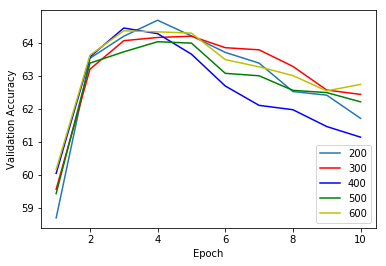

In [35]:
xx=epo
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xx,epa1,label='200')
plt.plot(xx,epa2,'r',label='300')
plt.plot(xx,epa3,'b',label='400')
plt.plot(xx,epa4,'g',label='500')
plt.plot(xx,epa5,'y',label='600')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.show()

In [19]:
class CNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, vocab_size):

        super(CNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding.from_pretrained(weight,freeze=True)
    
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)

        self.linear = nn.Linear(hidden_size, num_classes)

    def forward(self, x1, lengths1,x2, lengths2):
        batch_size1, seq_len1 = x1.size()
        batch_size2, seq_len2 = x2.size()
        
        embed1 = self.embedding(x1)
        embed2 = self.embedding(x2)        
        #First sentence
        hidden1 = self.conv1(embed1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size1, seq_len1, hidden1.size(-1))

        hidden1 = self.conv2(hidden1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size1, seq_len1, hidden1.size(-1))
        hidden1 = torch.sum(hidden1, dim=1)
       
        
        #second sentence
        hidden2 = self.conv1(embed2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size2, seq_len2, hidden2.size(-1))

        hidden2 = self.conv2(hidden2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size2, seq_len2, hidden2.size(-1))
        hidden2 = torch.sum(hidden2, dim=1)
        
        hiddenfinal = torch.mul(hidden1, hidden2)
        logits = self.linear(hiddenfinal)
        return logits

llist=[]
pl=[]
pa=[]
epl=[]
epa=[]
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data1, lengths1,data2, lengths2, labels in loader:
        data_batch1, lengths_batch1,data_batch2, lengths_batch2, label_batch = data1, lengths1,data2, lengths2, labels
        outputs = F.softmax(model(data_batch1, lengths_batch1,data_batch2, lengths_batch2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
        llist.append([data1,data2,labels,predicted])
    return (100 * correct / total)


model = CNN(emb_size=300, hidden_size=200, num_layers=2, num_classes=3, vocab_size=50002)

learning_rate = 3e-4
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    l=0
    a=0
    c=0
    for i, (data1, lengths1, data2, lengths2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data1, lengths1,data2, lengths2)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            c=c+1
            l=l+loss.item()
            a=a+val_acc
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))
            pa.append(val_acc)
            pl.append(loss.item())
    epl.append(l/c)
    epa.append(a/c)

Epoch: [1/10], Step: [101/3125], Validation Acc: 34.0
Epoch: [1/10], Step: [201/3125], Validation Acc: 37.6
Epoch: [1/10], Step: [301/3125], Validation Acc: 42.7
Epoch: [1/10], Step: [401/3125], Validation Acc: 38.7
Epoch: [1/10], Step: [501/3125], Validation Acc: 39.7
Epoch: [1/10], Step: [601/3125], Validation Acc: 43.4
Epoch: [1/10], Step: [701/3125], Validation Acc: 47.6
Epoch: [1/10], Step: [801/3125], Validation Acc: 45.9
Epoch: [1/10], Step: [901/3125], Validation Acc: 50.5
Epoch: [1/10], Step: [1001/3125], Validation Acc: 48.4
Epoch: [1/10], Step: [1101/3125], Validation Acc: 48.9
Epoch: [1/10], Step: [1201/3125], Validation Acc: 50.6
Epoch: [1/10], Step: [1301/3125], Validation Acc: 53.9
Epoch: [1/10], Step: [1401/3125], Validation Acc: 50.7
Epoch: [1/10], Step: [1501/3125], Validation Acc: 55.3
Epoch: [1/10], Step: [1601/3125], Validation Acc: 48.3
Epoch: [1/10], Step: [1701/3125], Validation Acc: 53.8
Epoch: [1/10], Step: [1801/3125], Validation Acc: 55.8
Epoch: [1/10], Step

Epoch: [5/10], Step: [2701/3125], Validation Acc: 64.0
Epoch: [5/10], Step: [2801/3125], Validation Acc: 60.6
Epoch: [5/10], Step: [2901/3125], Validation Acc: 63.6
Epoch: [5/10], Step: [3001/3125], Validation Acc: 62.1
Epoch: [5/10], Step: [3101/3125], Validation Acc: 62.1
Epoch: [6/10], Step: [101/3125], Validation Acc: 61.5
Epoch: [6/10], Step: [201/3125], Validation Acc: 62.7
Epoch: [6/10], Step: [301/3125], Validation Acc: 61.4
Epoch: [6/10], Step: [401/3125], Validation Acc: 63.1
Epoch: [6/10], Step: [501/3125], Validation Acc: 62.3
Epoch: [6/10], Step: [601/3125], Validation Acc: 63.7
Epoch: [6/10], Step: [701/3125], Validation Acc: 62.4
Epoch: [6/10], Step: [801/3125], Validation Acc: 62.8
Epoch: [6/10], Step: [901/3125], Validation Acc: 62.5
Epoch: [6/10], Step: [1001/3125], Validation Acc: 62.9
Epoch: [6/10], Step: [1101/3125], Validation Acc: 62.5
Epoch: [6/10], Step: [1201/3125], Validation Acc: 62.0
Epoch: [6/10], Step: [1301/3125], Validation Acc: 62.0
Epoch: [6/10], Step

Epoch: [10/10], Step: [2201/3125], Validation Acc: 64.2
Epoch: [10/10], Step: [2301/3125], Validation Acc: 62.8
Epoch: [10/10], Step: [2401/3125], Validation Acc: 62.0
Epoch: [10/10], Step: [2501/3125], Validation Acc: 63.3
Epoch: [10/10], Step: [2601/3125], Validation Acc: 62.5
Epoch: [10/10], Step: [2701/3125], Validation Acc: 62.3
Epoch: [10/10], Step: [2801/3125], Validation Acc: 62.8
Epoch: [10/10], Step: [2901/3125], Validation Acc: 62.4
Epoch: [10/10], Step: [3001/3125], Validation Acc: 63.1
Epoch: [10/10], Step: [3101/3125], Validation Acc: 61.8


In [20]:
epa

[50.87419354838708,
 59.635483870967754,
 60.916129032258084,
 61.84193548387097,
 62.21612903225805,
 62.27096774193548,
 62.858064516129026,
 63.099999999999994,
 62.47096774193548,
 62.39999999999999]

In [21]:
epl

[1.0023843549912976,
 0.861826817835531,
 0.8082458146156803,
 0.7965882305176027,
 0.7654327231068765,
 0.6627340566727423,
 0.6651113119817549,
 0.5898858299178462,
 0.5877346252241442,
 0.5402871947134694]

In [3]:
epa1=[50.87419354838708,
 59.635483870967754,
 60.916129032258084,
 61.84193548387097,
 62.21612903225805,
 62.27096774193548,
 62.858064516129026,
 63.099999999999994,
 62.47096774193548,
 62.39999999999999]
epa2=[51.929032258064524,
 60.13870967741936,
 62.07096774193549,
 63.43548387096774,
 63.29677419354839,
 63.390322580645154,
 63.63225806451613,
 63.464516129032255,
 64.06129032258066,
 64.38064516129032]
epa3=[52.312903225806444,
 60.5225806451613,
 62.15483870967743,
 62.49677419354839,
 62.638709677419364,
 62.841935483870955,
 63.099999999999994,
 63.47419354838711,
 63.73225806451614,
 64.26129032258063]
epa4=[52.50645161290323,
 60.070967741935476,
 62.16129032258065,
 62.87419354838708,
 63.71935483870968,
 63.93870967741935,
 64.10322580645165,
 64.3225806451613,
 64.47096774193548,
 64.7032258064516]
epa5=[51.86451612903224,
 60.358064516129026,
 61.948387096774205,
 63.177419354838726,
 64.19354838709678,
 64.39677419354838,
 64.76774193548387,
 65.18064516129031,
 65.64516129032256,
 65.48709677419355]



epa11=[58.690322580645166,
 63.53225806451614,
 64.19999999999999,
 64.68387096774194,
 64.20967741935482,
 63.70967741935484,
 63.38387096774192,
 62.52258064516129,
 62.41290322580647,
 61.70967741935484]
epa22=[59.56129032258063,
 63.2,
 64.06451612903226,
 64.16129032258064,
 64.2,
 63.85161290322581,
 63.78709677419356,
 63.28387096774193,
 62.567741935483866,
 62.435483870967744]
epa33=[60.04193548387097,
 63.5741935483871,
 64.44838709677418,
 64.27741935483871,
 63.65483870967742,
 62.690322580645166,
 62.10322580645161,
 61.97096774193549,
 61.461290322580645,
 61.13870967741936]
epa44=[59.429032258064524,
 63.38387096774194,
 63.725806451612904,
 64.03225806451613,
 63.99032258064515,
 63.07419354838709,
 63.000000000000014,
 62.55806451612902,
 62.49032258064516,
 62.209677419354854]
epa55=[60.15806451612904,
 63.62258064516128,
 64.36451612903225,
 64.33225806451614,
 64.29354838709678,
 63.490322580645156,
 63.27096774193548,
 63.00645161290323,
 62.54193548387097,
 62.73870967741936]
epo=range(1,11)

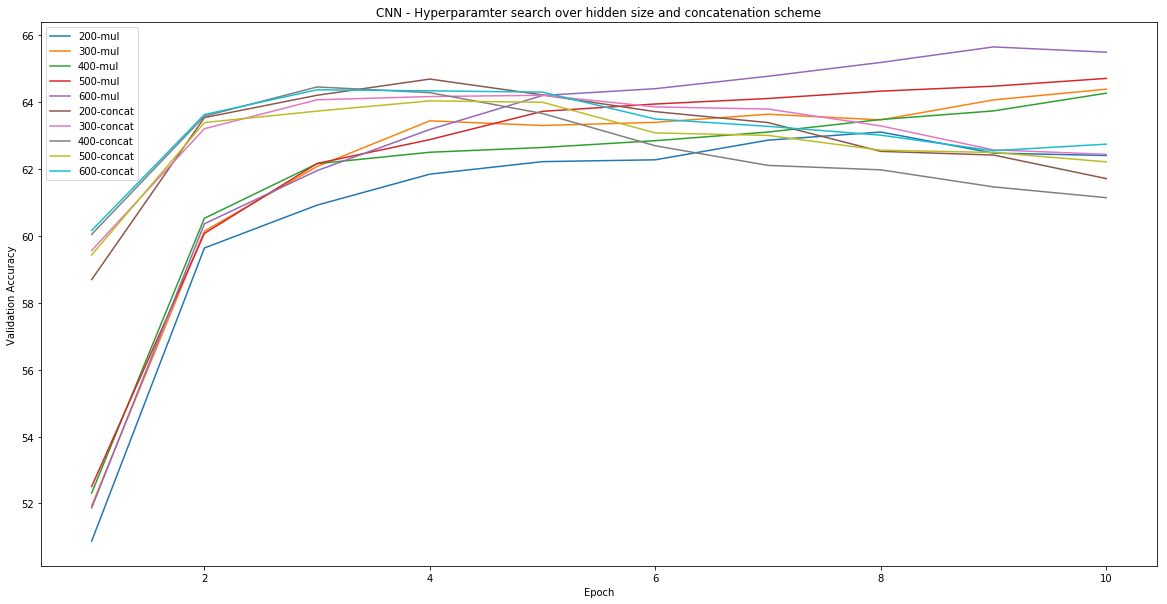

In [4]:
xx=epo
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(20,10))
plt.plot(xx,epa1,label='200-mul')
plt.plot(xx,epa2,label='300-mul')
plt.plot(xx,epa3,label='400-mul')
plt.plot(xx,epa4,label='500-mul')
plt.plot(xx,epa5,label='600-mul')
plt.plot(xx,epa11,label='200-concat')
plt.plot(xx,epa22,label='300-concat')
plt.plot(xx,epa33,label='400-concat')
plt.plot(xx,epa44,label='500-concat')
plt.plot(xx,epa55,label='600-concat')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('CNN - Hyperparamter search over hidden size and concatenation scheme')
plt.show()

In [5]:
epl1=[0.878424834820532,
 0.7711552304606284,
 0.7682500808469711,
 0.6989930925830719,
 0.6287361306528891,
 0.6090535867598749,
 0.6037586831277416,
 0.5739766436238443,
 0.5228034027161137,
 0.44693728512333286]
epl2=[0.8704382911805184,
 0.7923051272669146,
 0.7163844877673734,
 0.6646641185206752,
 0.6345962584018707,
 0.6127617551434424,
 0.5138344178276677,
 0.4679246515996994,
 0.43309745480937345,
 0.3548191199379583]
epl3=[0.9058496990511494,
 0.8169341568023928,
 0.73345104148311,
 0.702442301857856,
 0.653123487387934,
 0.6048713586022777,
 0.48064984909949765,
 0.4070366721960806,
 0.3844398327412144,
 0.33707943174146837]
epl4=[0.8947979961672137,
 0.8048133888552266,
 0.7067869488270052,
 0.6557261117043034,
 0.649998927308667,
 0.5383199251467182,
 0.4668583370024158,
 0.38761636326389926,
 0.34400838949987966,
 0.30671721216171016]
epl5=[0.8360626601403759,
 0.7915611267089844,
 0.7235932157885644,
 0.6791041022346865,
 0.5987347585539664,
 0.5031779129658976,
 0.4353878550952481,
 0.3277960462916282,
 0.32129123662748643,
 0.24950919732932123]
epl11=[1.0023843549912976,
 0.861826817835531,
 0.8082458146156803,
 0.7965882305176027,
 0.7654327231068765,
 0.6627340566727423,
 0.6651113119817549,
 0.5898858299178462,
 0.5877346252241442,
 0.5402871947134694]
epl22=[0.9498487037997092,
 0.8779602550691173,
 0.8158003822449715,
 0.813246113638724,
 0.7249480197506566,
 0.6530645258965031,
 0.6106266860039004,
 0.5858345637398381,
 0.5227122854801917,
 0.5007675895767827]
epl33=[0.970403048299974,
 0.9274333580847709,
 0.8115223857664293,
 0.7505089592549109,
 0.6984027258811458,
 0.6465385594675618,
 0.5807763472680123,
 0.5628122543134997,
 0.5177978575229645,
 0.3945812828117801]
epl44=[1.0039465427398682,
 0.8845336360316123,
 0.810328568181684,
 0.7850040947237322,
 0.7267152782409422,
 0.6566151457448159,
 0.5377710548139387,
 0.5037981622642086,
 0.4263572692871094,
 0.38521302611597125]
epl55=[0.9587537896248602,
 0.8539225401416901,
 0.8019973751037351,
 0.7264728103914568,
 0.6924910554962773,
 0.5766750641407505,
 0.5828812131958623,
 0.4674095424913591,
 0.42386413966455766,
 0.43481479777443793]

epo=range(1,11)

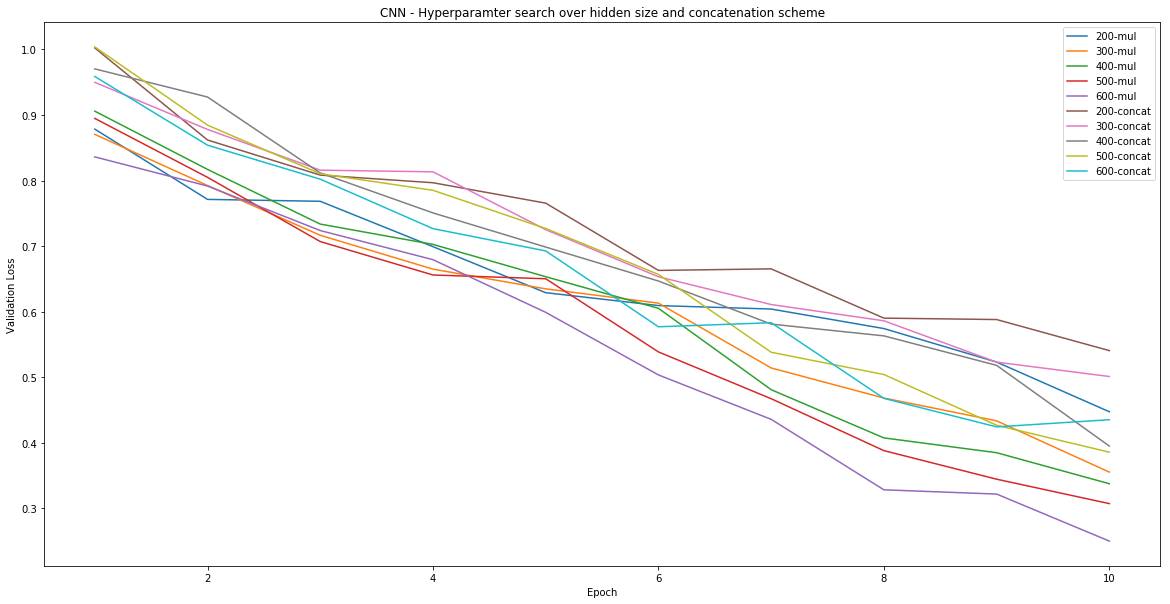

In [6]:
xx=epo
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(20,10))
plt.plot(xx,epl1,label='200-mul')
plt.plot(xx,epl2,label='300-mul')
plt.plot(xx,epl3,label='400-mul')
plt.plot(xx,epl4,label='500-mul')
plt.plot(xx,epl5,label='600-mul')
plt.plot(xx,epl11,label='200-concat')
plt.plot(xx,epl22,label='300-concat')
plt.plot(xx,epl33,label='400-concat')
plt.plot(xx,epl44,label='500-concat')
plt.plot(xx,epl55,label='600-concat')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('CNN - Hyperparamter search over hidden size and concatenation scheme')
plt.show()